# Solving MAXCUT Using QAOA in `qiskit`

Max-Cut is an NP-complete problem, with applications in clustering, network science, and statistical physics. To grasp how practical applications are mapped into given Max-Cut instances, consider a system of many people that can interact and influence each other. Individuals can be represented by vertices of a graph, and their interactions seen as pairwise connections between vertices of the graph, or edges. With this representation in mind, it is easy to model typical marketing problems. For example, suppose that it is assumed that individuals will influence each other’s buying decisions, and knowledge is given about how strong they will influence each other. The influence can be modeled by weights assigned on each edge of the graph. It is possible then to predict the outcome of a marketing strategy in which products are offered for free to some individuals, and then ask which is the optimal subset of individuals that should get the free products, in order to maximize revenues.



Consider an $n$-node undirected graph $G = (V, E)$ where $|V| = n$ with edge weights $w_{ij} \geq 0$, $w_{ij} = w_{ji}$ for $(i, j) \in E$. A cut is defined as a partition of the original set $V$ into two subsets. The cost function to be optimized is in this case the sum of weights of edges connecting points in the two different subsets, crossing the cut.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import json
import networkx as nx
import random
import copy
# useful additional packages
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import numpy as np
import networkx as nx
import seaborn as sns

from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.problems import QuadraticProgram

sns.set_theme()


In [2]:
import qiskit
qiskit.__version__

'0.21.2'

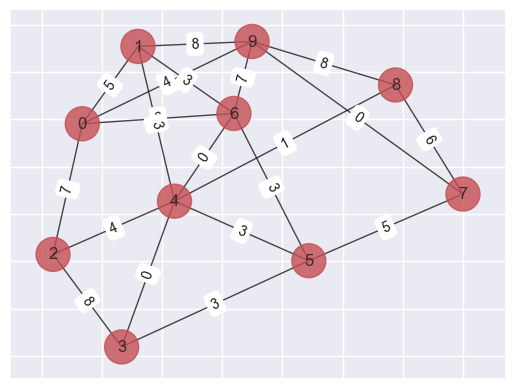

In [3]:
# Generating a graph of 4 nodes
G = nx.connected_watts_strogatz_graph(10,k=4,p=0.5)
for (u, v) in G.edges():
    G.edges[u,v]['weight'] = random.randint(0,10)
    

colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)
n = 10

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

draw_graph(G, colors, pos)

In [4]:
# Computing the weight matrix from the random graph
w = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i,j,default=0)
        if temp != 0:
            w[i,j] = temp['weight']
print(w)

[[0. 5. 7. 0. 0. 0. 3. 0. 0. 4.]
 [5. 0. 0. 0. 3. 0. 3. 0. 0. 8.]
 [7. 0. 0. 8. 4. 0. 0. 0. 0. 0.]
 [0. 0. 8. 0. 0. 3. 0. 0. 0. 0.]
 [0. 3. 4. 0. 0. 3. 0. 0. 1. 0.]
 [0. 0. 0. 3. 3. 0. 3. 5. 0. 0.]
 [3. 3. 0. 0. 0. 3. 0. 0. 0. 7.]
 [0. 0. 0. 0. 0. 5. 0. 0. 6. 0.]
 [0. 0. 0. 0. 1. 0. 0. 6. 0. 8.]
 [4. 8. 0. 0. 0. 0. 7. 0. 8. 0.]]


case = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0] cost = 19.0
case = [0, 1, 0, 0, 0, 0, 0, 0, 0, 0] cost = 19.0
case = [1, 1, 0, 0, 0, 0, 0, 0, 0, 0] cost = 28.0
case = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0] cost = 19.0
case = [1, 0, 1, 0, 0, 0, 0, 0, 0, 0] cost = 24.0
case = [0, 1, 1, 0, 0, 0, 0, 0, 0, 0] cost = 38.0
case = [1, 1, 1, 0, 0, 0, 0, 0, 0, 0] cost = 33.0
case = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0] cost = 11.0
case = [1, 0, 0, 1, 0, 0, 0, 0, 0, 0] cost = 30.0
case = [0, 1, 0, 1, 0, 0, 0, 0, 0, 0] cost = 30.0
case = [1, 1, 0, 1, 0, 0, 0, 0, 0, 0] cost = 39.0
case = [0, 0, 1, 1, 0, 0, 0, 0, 0, 0] cost = 14.0
case = [1, 0, 1, 1, 0, 0, 0, 0, 0, 0] cost = 19.0
case = [0, 1, 1, 1, 0, 0, 0, 0, 0, 0] cost = 33.0
case = [1, 1, 1, 1, 0, 0, 0, 0, 0, 0] cost = 28.0
case = [0, 0, 0, 0, 1, 0, 0, 0, 0, 0] cost = 11.0
case = [1, 0, 0, 0, 1, 0, 0, 0, 0, 0] cost = 30.0
case = [0, 1, 0, 0, 1, 0, 0, 0, 0, 0] cost = 24.0
case = [1, 1, 0, 0, 1, 0, 0, 0, 0, 0] cost = 33.0
c

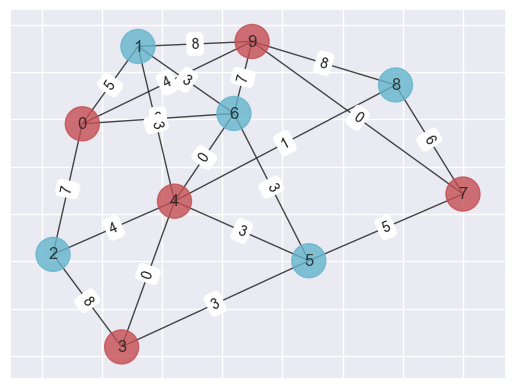

In [5]:
best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i,j]*x[i]*(1-x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    print('case = ' + str(x)+ ' cost = ' + str(cost))

colors = ['r' if xbest_brute[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)
print('\nBest solution = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute))

In [6]:
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
print(qp.prettyprint())

Problem name: Max-cut

Maximize
  -10*x_0*x_1 - 14*x_0*x_2 - 6*x_0*x_6 - 8*x_0*x_9 - 6*x_1*x_4 - 6*x_1*x_6
  - 16*x_1*x_9 - 16*x_2*x_3 - 8*x_2*x_4 - 6*x_3*x_5 - 6*x_4*x_5 - 2*x_4*x_8
  - 6*x_5*x_6 - 10*x_5*x_7 - 14*x_6*x_9 - 12*x_7*x_8 - 16*x_8*x_9 + 19*x_0
  + 19*x_1 + 19*x_2 + 11*x_3 + 11*x_4 + 14*x_5 + 16*x_6 + 11*x_7 + 15*x_8
  + 27*x_9

Subject to
  No constraints

  Binary variables (10)
    x_0 x_1 x_2 x_3 x_4 x_5 x_6 x_7 x_8 x_9



In [7]:
qubitOp, offset = qp.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: -40.5
Ising Hamiltonian:
2.5 * IIIIIIIIZZ
+ 3.5 * IIIIIIIZIZ
+ 4.0 * IIIIIIZZII
+ 1.5 * IIIIIZIIZI
+ 2.0 * IIIIIZIZII
+ 1.5 * IIIIZIZIII
+ 1.5 * IIIIZZIIII
+ 1.5 * IIIZIIIIIZ
+ 1.5 * IIIZIIIIZI
+ 1.5 * IIIZZIIIII
+ 2.5 * IIZIZIIIII
+ 0.5 * IZIIIZIIII
+ 3.0 * IZZIIIIIII
+ 2.0 * ZIIIIIIIIZ
+ 4.0 * ZIIIIIIIZI
+ 3.5 * ZIIZIIIIII
+ 4.0 * ZZIIIIIIII


In [8]:
# solving Quadratic Program using exact classical eigensolver
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result.prettyprint())
print('\nBest solution BRUTE FORCE = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute))

objective function value: 71.0
variable values: x_0=0.0, x_1=1.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0, x_8=1.0, x_9=0.0
status: SUCCESS

Best solution BRUTE FORCE = [0, 1, 1, 0, 0, 1, 1, 0, 1, 0] cost = 71.0


### Check that the full Hamiltonian gives the right cost

energy: -30.5
max-cut objective: -71.0
solution: [0 1 1 0 0 1 1 0 1 0]
solution objective: 71.0


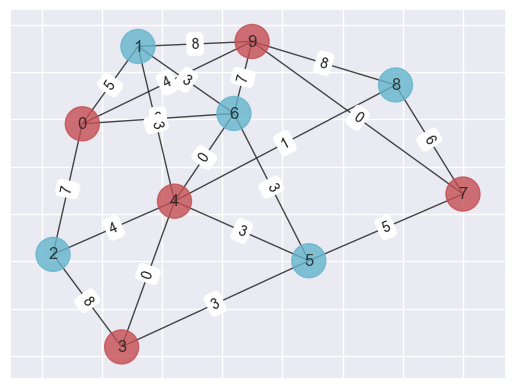

In [9]:
ee = NumPyMinimumEigensolver()

# Calculate the min eigenvalue
actual_result = ee.compute_minimum_eigenvalue(qubitOp)

x = max_cut.sample_most_likely(actual_result.eigenstate)
print('energy:', actual_result.eigenvalue.real)
print('max-cut objective:', actual_result.eigenvalue.real + offset)
print('solution:', x)
print('solution objective:', qp.objective.evaluate(x))

colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

# Setting the parameters for the run

- `p_max` - The numbers of layers for the p
- `optimizer` -- The Optimization technique to use for the local optimizer. We'll use a default optimzation algorithm of COBYLA (it has decent performance but also is fast)
- `Initialisation` -- this is an Initialisation object that parameterises the initialiasation technique being used. For this run we're using a `random` appraoch to initial parameters

Running it on quantum computer
We run the optimization routine using a feedback loop with a quantum computer that uses trial functions built with Y single-qubit rotations, $U_\mathrm{single}(\theta) = \prod_{i=1}^n Y(\theta_{i})$, and entangler steps $U_{entangler}$.

In [10]:
algorithm_globals.random_seed = 12321
seed = 10598
backend = Aer.get_backend("aer_simulator_statevector")
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

energy: -30.498958250219417
time: 4.890154123306274
max-cut objective: -70.99895825021942
solution: [0. 1. 1. 0. 0. 1. 1. 0. 1. 0.]
solution objective: 71.0


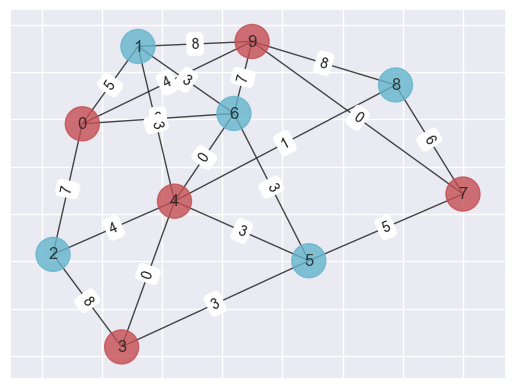

In [14]:
spsa = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=1, entanglement="linear")
vqe = VQE(ry, optimizer=spsa, quantum_instance=quantum_instance)

# run VQE
result = vqe.compute_minimum_eigenvalue(qubitOp)

# print results
x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

# plot results
colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

In [15]:
result

objective function value: 71.0
variable values: x_0=0.0, x_1=1.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0, x_8=1.0, x_9=0.0
status: SUCCESS


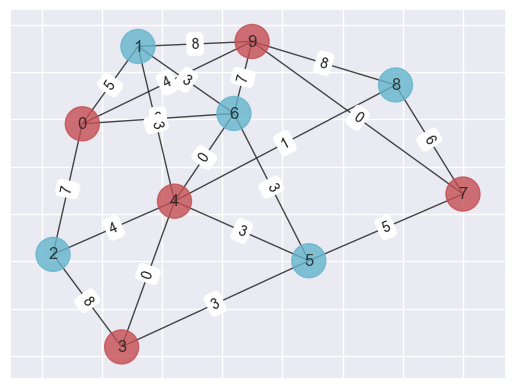

In [16]:
# create minimum eigen optimizer based on VQE
vqe_optimizer = MinimumEigenOptimizer(vqe)

# solve quadratic program
result = vqe_optimizer.solve(qp)
print(result.prettyprint())

colors = ["r" if result.x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

# Compare Optimization Problems

energy: -30.498471074589776
time: 4.991516828536987
max-cut objective: -70.99847107458977
solution: [1. 0. 0. 1. 1. 0. 0. 1. 0. 1.]
solution objective: 71.0


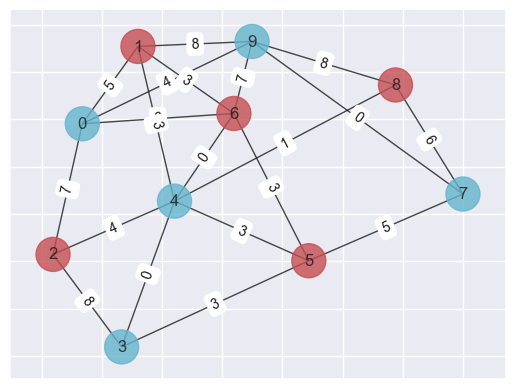

In [18]:
spsa = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=1, entanglement="linear")
vqe = VQE(ry, optimizer=spsa, quantum_instance=quantum_instance)

# run VQE
result = vqe.compute_minimum_eigenvalue(qubitOp)

# print results
x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

# plot results
colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

In [19]:
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP, SPSA, NELDER_MEAD

# Run optimisation code
optimizers = [COBYLA(maxiter=3000), SPSA(maxiter=5000), NELDER_MEAD(maxfev=50000)]
converge_cnts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)
num_qubits = qubitOp.num_qubits

In [20]:
init_state = np.random.rand(num_qubits)*2*np.pi
print(f"The initial state is {init_state}")
n_restarts = 1
optimizer_results = []

result = {"algo": None,"result": None}

for i in range(len(optimizers)):
    optimizer = optimizers[i]
    print(f'Testing Optimizer {i+1}: {type(optimizer).__name__}')

    counts = []
    values = []
    
    # Callback definition
    def store_intermediate_result(eval_count, parameters, mean, std):
        if eval_count % 100 == 0:
            print(f"{type(optimizer).__name__} iteration {eval_count} \t cost function {mean}")
        counts.append(eval_count)
        values.append(mean)

    # Define the systems of rotation for x and y
    ry = TwoLocal(num_qubits, "ry", "cz", reps=1, entanglement="linear")

    # VQE definition
    vqe = VQE(ry, optimizer=optimizer, quantum_instance=quantum_instance, callback=store_intermediate_result)
    algo_result = vqe.compute_minimum_eigenvalue(qubitOp)
    # print results
    x = max_cut.sample_most_likely(algo_result.eigenstate)
    print("energy:", algo_result.eigenvalue.real)
    print("time:", algo_result.optimizer_time)
    print("max-cut objective:", algo_result.eigenvalue.real + offset)
    print("solution:", x)
    print("solution objective:", qp.objective.evaluate(x))
    
    # Store result
    result_opt = copy.deepcopy(result)
    result_opt["algo"] = type(optimizer).__name__
    result_opt["result"] = algo_result
    optimizer_results.append(result_opt)
    # Convergence array
    total_counts = np.arange(0, len(counts))
    converge_cnts[i] = total_counts
    converge_vals[i] = np.asarray(values)

The initial state is [3.50676123 4.65102546 2.24950668 2.07088143 3.04580042 4.33498265
 4.63735991 0.79101233 1.28341637 5.79627005]
Testing Optimizer 1: COBYLA
COBYLA iteration 100 	 cost function -23.11205300576107
COBYLA iteration 200 	 cost function -23.83019639401481
COBYLA iteration 300 	 cost function -25.83884068890986
COBYLA iteration 400 	 cost function -26.5170515713792
COBYLA iteration 500 	 cost function -27.936648373938066
COBYLA iteration 600 	 cost function -30.296452081641522
COBYLA iteration 700 	 cost function -30.49175519766436
COBYLA iteration 800 	 cost function -30.499660844697438
COBYLA iteration 900 	 cost function -30.499997570331047
energy: -30.499999896910122
time: 7.385188102722168
max-cut objective: -70.99999989691013
solution: [0. 1. 1. 0. 0. 1. 1. 0. 1. 0.]
solution objective: 71.0
Testing Optimizer 2: SPSA
SPSA iteration 100 	 cost function -13.611271227551917
SPSA iteration 200 	 cost function -16.15725022773678
SPSA iteration 300 	 cost function -18.

NELDER_MEAD iteration 2700 	 cost function -29.443696915648623
NELDER_MEAD iteration 2800 	 cost function -29.4531284901163
NELDER_MEAD iteration 2900 	 cost function -29.462614663110436
NELDER_MEAD iteration 3000 	 cost function -29.486157154111407
NELDER_MEAD iteration 3100 	 cost function -29.514186646681146
NELDER_MEAD iteration 3200 	 cost function -29.542718891423043
NELDER_MEAD iteration 3300 	 cost function -29.563686055958936
NELDER_MEAD iteration 3400 	 cost function -29.598201572922154
NELDER_MEAD iteration 3500 	 cost function -29.621070959435247
NELDER_MEAD iteration 3600 	 cost function -29.675649690374918
NELDER_MEAD iteration 3700 	 cost function -29.802590683982665
NELDER_MEAD iteration 3800 	 cost function -30.041156415563623
NELDER_MEAD iteration 3900 	 cost function -30.1175552617173
NELDER_MEAD iteration 4000 	 cost function -30.15147911069122
NELDER_MEAD iteration 4100 	 cost function -30.15670072367031
NELDER_MEAD iteration 4200 	 cost function -30.15808560252956

In [22]:
len(converge_cnts[0]) == len(converge_vals[0])

True

In [23]:
import pylab

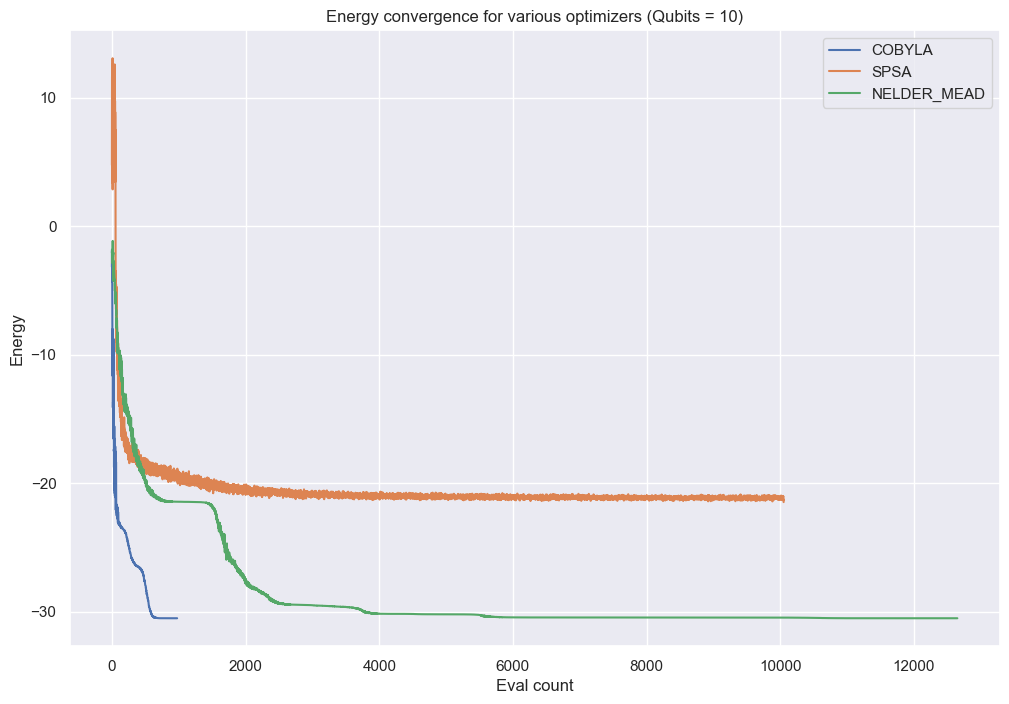

In [24]:
pylab.rcParams['figure.figsize'] = (12, 8)
for i in range(len(optimizers)):
    pylab.plot(converge_cnts[i], converge_vals[i], label=type(optimizers[i]).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Energy convergence for various optimizers (Qubits = 10)')
pylab.legend(loc='upper right')

In [25]:
def binatodeci(binary):
    return sum(val*(2**idx) for idx, val in enumerate(reversed(binary)))

index_of_optimal_state = int(binatodeci(max_cut.sample_most_likely(algo_result.eigenstate)))
max(algo_result.eigenstate)


(0.9999999998471865+0j)

# Random restarts



In [26]:

print(f"The initial state is {init_state}")

n_restarts = 3

optimizer_results_restarts = []
for i in range(len(optimizers)):
    optimizer = optimizers[i]
    print(f'Testing Optimizer {i+1}: {type(optimizer).__name__}')

    counts = []
    values = []
    
    # Callback definition
    def store_intermediate_result(eval_count, parameters, mean, std):
        if eval_count % 100 == 0:
            print(f"{type(optimizer).__name__} iteration {eval_count} \t cost function {mean}")
        counts.append(eval_count)
        values.append(mean)
    
    for restart in range(n_restarts):
        print(restart)
        init_state = np.random.rand(4)*2*np.pi

        # Define the systems of rotation for x and y
        ry = TwoLocal(num_qubits, "ry", "cz", reps=2, entanglement="linear")
        
        # VQE definition
        vqe = VQE(ry, optimizer=optimizer, quantum_instance=quantum_instance, callback=store_intermediate_result)
        algo_result = vqe.compute_minimum_eigenvalue(qubitOp)
        
        # Sample most liklely eigenstate
        x = max_cut.sample_most_likely(algo_result.eigenstate)
        print("energy:", algo_result.eigenvalue.real)
        print("time:", algo_result.optimizer_time)
        print("max-cut objective:", algo_result.eigenvalue.real + offset)
        print("solution:", x)
        print("solution objective:", qp.objective.evaluate(x))

        # Store result
        result_opt = copy.deepcopy(result)
        result_opt["algo"] = type(optimizer).__name__
        result_opt["result"] = algo_result
        optimizer_results_restarts.append(result_opt)
    
    # Convergence array
    total_counts = np.arange(0, len(counts))
    converge_cnts[i] = total_counts
    converge_vals[i] = np.asarray(values)

The initial state is [3.50676123 4.65102546 2.24950668 2.07088143 3.04580042 4.33498265
 4.63735991 0.79101233 1.28341637 5.79627005]
Testing Optimizer 1: COBYLA
0
COBYLA iteration 100 	 cost function -26.63477067566327
COBYLA iteration 200 	 cost function -30.106557913579238
COBYLA iteration 300 	 cost function -30.453588599765553
COBYLA iteration 400 	 cost function -30.48324819540808
COBYLA iteration 500 	 cost function -30.491177502302254
COBYLA iteration 600 	 cost function -30.495327936381063
COBYLA iteration 700 	 cost function -30.49756792301987
COBYLA iteration 800 	 cost function -30.498884889383525
COBYLA iteration 900 	 cost function -30.499381006197193
COBYLA iteration 1000 	 cost function -30.499667587459008
COBYLA iteration 1100 	 cost function -30.499809680310094
COBYLA iteration 1200 	 cost function -30.499903705716214
COBYLA iteration 1300 	 cost function -30.499958693820368
COBYLA iteration 1400 	 cost function -30.499974861904956
COBYLA iteration 1500 	 cost functio

SPSA iteration 7600 	 cost function -29.44087487014367
SPSA iteration 7700 	 cost function -29.809499554532625
SPSA iteration 7800 	 cost function -29.565424082536072
SPSA iteration 7900 	 cost function -29.80084736005252
SPSA iteration 8000 	 cost function -29.505906053309833
SPSA iteration 8100 	 cost function -29.43420148885598
SPSA iteration 8200 	 cost function -29.76735683382011
SPSA iteration 8300 	 cost function -29.47120978081603
SPSA iteration 8400 	 cost function -29.856982941797618
SPSA iteration 8500 	 cost function -29.67374861429089
SPSA iteration 8600 	 cost function -29.90067061479483
SPSA iteration 8700 	 cost function -29.848860481008302
SPSA iteration 8800 	 cost function -29.618981555572436
SPSA iteration 8900 	 cost function -29.865141121022123
SPSA iteration 9000 	 cost function -29.64892155179562
SPSA iteration 9100 	 cost function -29.233171305759004
SPSA iteration 9200 	 cost function -29.965594159113014
SPSA iteration 9300 	 cost function -29.87818216076416
S

SPSA iteration 1900 	 cost function -24.411527707258063
SPSA iteration 2000 	 cost function -24.53921886951074
SPSA iteration 2100 	 cost function -24.879599899850188
SPSA iteration 2200 	 cost function -25.41712161101621
SPSA iteration 2300 	 cost function -25.411641431089496
SPSA iteration 2400 	 cost function -25.27739062487594
SPSA iteration 2500 	 cost function -24.76071607673129
SPSA iteration 2600 	 cost function -25.471903137506406
SPSA iteration 2700 	 cost function -25.257881363429874
SPSA iteration 2800 	 cost function -25.581731261247782
SPSA iteration 2900 	 cost function -25.70925882831438
SPSA iteration 3000 	 cost function -25.78294559426116
SPSA iteration 3100 	 cost function -25.667086536704
SPSA iteration 3200 	 cost function -26.014837023089434
SPSA iteration 3300 	 cost function -26.013383030203066
SPSA iteration 3400 	 cost function -26.152563405821446
SPSA iteration 3500 	 cost function -26.62951279180591
SPSA iteration 3600 	 cost function -27.17398671038409
SPS

NELDER_MEAD iteration 5700 	 cost function -23.488034351880863
NELDER_MEAD iteration 5800 	 cost function -23.490071961159845
NELDER_MEAD iteration 5900 	 cost function -23.49094242043006
NELDER_MEAD iteration 6000 	 cost function -23.492206115949948
NELDER_MEAD iteration 6100 	 cost function -23.4926096610779
NELDER_MEAD iteration 6200 	 cost function -23.49294161288575
NELDER_MEAD iteration 6300 	 cost function -23.493263725066306
NELDER_MEAD iteration 6400 	 cost function -23.493464909618325
NELDER_MEAD iteration 6500 	 cost function -23.49354421513453
NELDER_MEAD iteration 6600 	 cost function -23.493630611257377
NELDER_MEAD iteration 6700 	 cost function -23.493650912003375
NELDER_MEAD iteration 6800 	 cost function -23.493703688612282
NELDER_MEAD iteration 6900 	 cost function -23.49377323103123
NELDER_MEAD iteration 7000 	 cost function -23.493849147922955
NELDER_MEAD iteration 7100 	 cost function -23.4940148113119
NELDER_MEAD iteration 7200 	 cost function -23.49416045278403
N

NELDER_MEAD iteration 6900 	 cost function -21.42850019931429
NELDER_MEAD iteration 7000 	 cost function -21.428810748681734
NELDER_MEAD iteration 7100 	 cost function -21.4291824192529
NELDER_MEAD iteration 7200 	 cost function -21.42967943135835
NELDER_MEAD iteration 7300 	 cost function -21.430238312421963
NELDER_MEAD iteration 7400 	 cost function -21.431129831547253
NELDER_MEAD iteration 7500 	 cost function -21.43285651514652
NELDER_MEAD iteration 7600 	 cost function -21.436199384359757
NELDER_MEAD iteration 7700 	 cost function -21.440589273606733
NELDER_MEAD iteration 7800 	 cost function -21.44301951106364
NELDER_MEAD iteration 7900 	 cost function -21.445432415726334
NELDER_MEAD iteration 8000 	 cost function -21.447635677350654
NELDER_MEAD iteration 8100 	 cost function -21.45084309136674
NELDER_MEAD iteration 8200 	 cost function -21.452304125560193
NELDER_MEAD iteration 8300 	 cost function -21.45809009137572
NELDER_MEAD iteration 8400 	 cost function -21.464029105395568


NELDER_MEAD iteration 2100 	 cost function -29.999595991468453
NELDER_MEAD iteration 2200 	 cost function -30.03484898007757
NELDER_MEAD iteration 2300 	 cost function -30.06423389694105
NELDER_MEAD iteration 2400 	 cost function -30.093294162136598
NELDER_MEAD iteration 2500 	 cost function -30.09691638348604
NELDER_MEAD iteration 2600 	 cost function -30.143899692763547
NELDER_MEAD iteration 2700 	 cost function -30.17228570423215
NELDER_MEAD iteration 2800 	 cost function -30.17998161427654
NELDER_MEAD iteration 2900 	 cost function -30.2142091090449
NELDER_MEAD iteration 3000 	 cost function -30.248599650804064
NELDER_MEAD iteration 3100 	 cost function -30.274125186543785
NELDER_MEAD iteration 3200 	 cost function -30.30099889502351
NELDER_MEAD iteration 3300 	 cost function -30.334558058815073
NELDER_MEAD iteration 3400 	 cost function -30.345188379548578
NELDER_MEAD iteration 3500 	 cost function -30.367748553703965
NELDER_MEAD iteration 3600 	 cost function -30.390812165369763


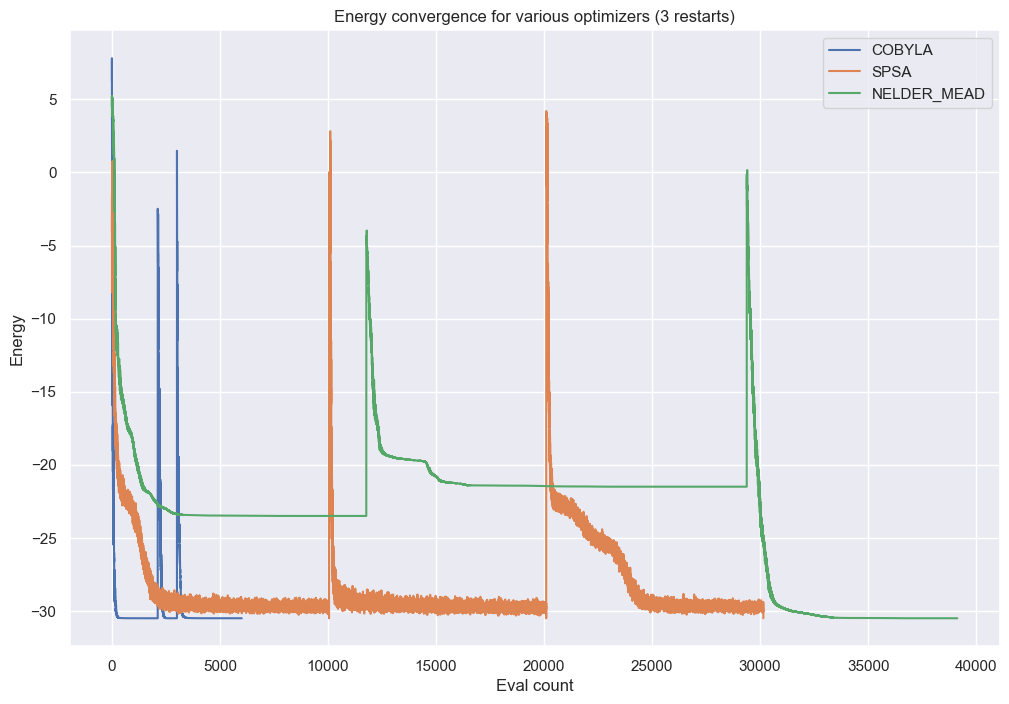

In [27]:
pylab.rcParams['figure.figsize'] = (12, 8)
for i in range(len(optimizers)):
    pylab.plot(converge_cnts[i], converge_vals[i], label=type(optimizers[i]).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Energy convergence for various optimizers (3 restarts)')
pylab.legend(loc='upper right')

In [76]:
import pandas as pd

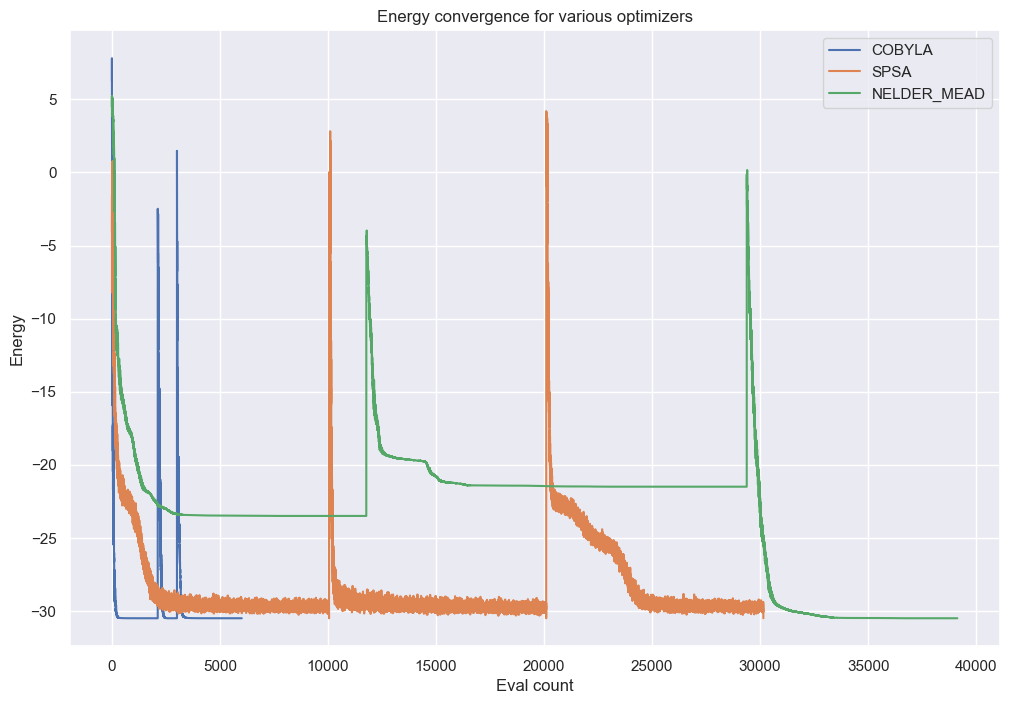

In [29]:
pylab.rcParams['figure.figsize'] = (12, 8)
for i in range(len(optimizers)):
    pylab.plot(converge_cnts[i], converge_vals[i], label=type(optimizers[i]).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Energy convergence for various optimizers')
pylab.legend(loc='upper right')

In [30]:
import qiskit.tools.jupyter

%qiskit_version_table

In [31]:
row_dict = {
    "algorithm" : None,
    "iter": None,
    "energy": None   
}

raw_results = []

In [32]:
# Loop through and create a dataframe for good clean results
for algo in range(len(converge_cnts)):
    for i in zip(converge_cnts[algo], converge_vals[algo]):
        row_copy = copy.deepcopy(row_dict)
        row_copy["algorithm"] = type(optimizers[algo]).__name__ 
        row_copy["iter"] = i[0]
        row_copy["energy"] = i[1]
        raw_results.append(row_copy)
        del row_copy

In [33]:
d_results = pd.DataFrame(raw_results)
d_results.to_csv("../data/results-large-maxcut-vqe.csv")

In [34]:
d_results.head()

,algorithm,iter,energy
0,COBYLA,0,6.243335
1,COBYLA,1,7.814497
2,COBYLA,2,4.379651
3,COBYLA,3,3.953185
4,COBYLA,4,2.549972


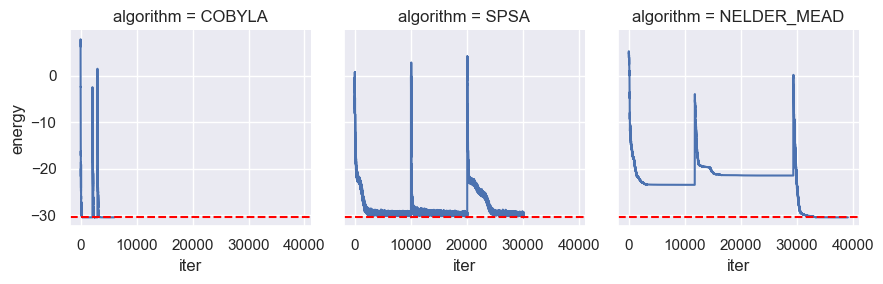

In [35]:
g = sns.FacetGrid(d_results, col='algorithm')
g.map(sns.lineplot, 'iter', 'energy')
g.map(plt.axhline, y=actual_result.eigenvalue.real, ls='--', c='red')
plt.show()

Find out how many function evaluations it took for each of the algorithms

In [36]:
d_counts_by_algorithm = d_results[["algorithm", "iter"]].groupby(["algorithm"]).count()
d_counts_by_algorithm = d_counts_by_algorithm.reset_index()
d_counts_by_algorithm

,algorithm,iter
0,COBYLA,6012
1,NELDER_MEAD,39131
2,SPSA,30153


In [38]:
d_counts_by_algorithm_dict = d_counts_by_algorithm.to_dict(orient="records")
d_counts_by_algorithm_dict

[{'algorithm': 'COBYLA', 'iter': 6012},
 {'algorithm': 'NELDER_MEAD', 'iter': 39131},
 {'algorithm': 'SPSA', 'iter': 30153}]

# QAOA (MAXCUT)

In [69]:
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver


# Set random seeds
algorithm_globals.random_seed = 12321
seed = 10598

# Get the QAOA backend
backend = Aer.get_backend("aer_simulator_statevector")
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)


print(f"The initial state is {init_state}")
optimizers = [
    COBYLA(), 
    SPSA(), 
    NELDER_MEAD()
]

n_restarts = 3
optimizer_results_restarts_qaoa = []
converge_cnts_qaoa = np.empty([len(optimizers)], dtype=object)
converge_vals_qaoa = np.empty([len(optimizers)], dtype=object)

qaoa_result = {"algo": None,"result": None}

for i in range(len(optimizers)):
    optimizer = optimizers[i]
    print(f"Testing Optimizer {i+1} for QAOA: {type(optimizer).__name__}, max fevals {d_counts_by_algorithm_dict[i]['iter']}")
    counts = []
    values = []    
    
    # Callback definition
    def store_intermediate_result(eval_count, parameters, mean, std):
        if eval_count % 100 == 0:
            print(f"{type(optimizer).__name__} iteration {eval_count} \t cost function {mean}")
        counts.append(eval_count)
        values.append(mean)
    
    restart = 1
    last_count = 0 
    while last_count < d_counts_by_algorithm_dict[i]['iter']:
        print(f"Current restart: {restart} and counter is {last_count}")
        init_state = np.random.rand(4)*2*np.pi
        # Use a QAOA
        qaoa = QAOA(reps=10, optimizer=optimizer, quantum_instance=quantum_instance, callback=store_intermediate_result)
        algo_result = qaoa.compute_minimum_eigenvalue(qubitOp)
        
        # Sample most liklely eigenstate
        x = max_cut.sample_most_likely(algo_result.eigenstate)
        print(f"Optimization took {len(counts)} iterations")
        print("energy:", algo_result.eigenvalue.real)
        print("time:", algo_result.optimizer_time)
        print("max-cut objective:", algo_result.eigenvalue.real + offset)
        print("solution:", x)
        print("solution objective:", qp.objective.evaluate(x))

        # Store result
        result_opt = copy.deepcopy(qaoa_result)
        result_opt["algo"] = type(optimizer).__name__
        result_opt["result"] = algo_result
        optimizer_results_restarts.append(result_opt)
        last_count = len(counts)
        restart += 1
    
    # Convergence array
    total_counts = np.arange(0, len(counts))
    converge_cnts_qaoa[i] = total_counts
    converge_vals_qaoa[i] = np.asarray(values)


The initial state is [5.77360045 5.2696389  1.24125189 4.83214733]
Testing Optimizer 1 for QAOA: COBYLA, max fevals 6012
Current restart: 1 and counter is 0
COBYLA iteration 100 	 cost function -10.961015742570497
COBYLA iteration 200 	 cost function -13.020206074258164
COBYLA iteration 300 	 cost function -13.989807369700173
COBYLA iteration 400 	 cost function -14.570571560499236
COBYLA iteration 500 	 cost function -14.912971941783695
COBYLA iteration 600 	 cost function -15.286053538620045
COBYLA iteration 700 	 cost function -15.614375339558954
COBYLA iteration 800 	 cost function -15.891663314628445
COBYLA iteration 900 	 cost function -16.123560900666064
COBYLA iteration 1000 	 cost function -16.316793723556962
Optimization took 1000 iterations
energy: -16.316793723556962
time: 19.062294006347656
max-cut objective: -56.81679372355696
solution: [0. 1. 1. 0. 0. 0. 1. 0. 1. 0.]
solution objective: 63.0
Current restart: 2 and counter is 1000
COBYLA iteration 100 	 cost function -2.6

Optimization took 2008 iterations
energy: -0.5657359674743134
time: 5.946254730224609
max-cut objective: -41.06573596747431
solution: [1. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
solution objective: 43.0
Current restart: 9 and counter is 2008
SPSA iteration 100 	 cost function 0.875004822131019
SPSA iteration 200 	 cost function 0.8118255794895098
Optimization took 2259 iterations
energy: 0.2304963386372283
time: 6.11598801612854
max-cut objective: -40.26950366136277
solution: [0. 1. 1. 0. 0. 0. 1. 1. 1. 1.]
solution objective: 43.0
Current restart: 10 and counter is 2259
SPSA iteration 100 	 cost function 1.6288928410712604
SPSA iteration 200 	 cost function 0.11202578885933062
Optimization took 2510 iterations
energy: -0.41800329540698006
time: 6.037337064743042
max-cut objective: -40.91800329540698
solution: [1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
solution objective: 19.0
Current restart: 11 and counter is 2510
SPSA iteration 100 	 cost function 0.22737556081664656
SPSA iteration 200 	 cost function 0.9

SPSA iteration 100 	 cost function -0.8151547713928764
SPSA iteration 200 	 cost function -0.3780029526636007
Optimization took 8283 iterations
energy: -0.21913803595742937
time: 6.356230020523071
max-cut objective: -40.71913803595743
solution: [1. 1. 1. 0. 1. 1. 1. 0. 0. 1.]
solution objective: 25.0
Current restart: 34 and counter is 8283
SPSA iteration 100 	 cost function 0.6200222943537724
SPSA iteration 200 	 cost function -0.661693333381097
Optimization took 8534 iterations
energy: -1.992052625760042
time: 6.3155786991119385
max-cut objective: -42.49205262576004
solution: [0. 0. 0. 1. 1. 0. 0. 1. 0. 0.]
solution objective: 33.0
Current restart: 35 and counter is 8534
SPSA iteration 100 	 cost function -0.2341935579370356
SPSA iteration 200 	 cost function 0.2901019873620678
Optimization took 8785 iterations
energy: -0.6736478028536388
time: 6.2694408893585205
max-cut objective: -41.17364780285364
solution: [0. 0. 1. 0. 1. 1. 0. 0. 0. 1.]
solution objective: 57.0
Current restart: 3

SPSA iteration 100 	 cost function 0.15463977532859358
SPSA iteration 200 	 cost function 0.4102989754508253
Optimization took 14307 iterations
energy: 0.46026817422684063
time: 6.4053261280059814
max-cut objective: -40.03973182577316
solution: [0. 0. 1. 1. 0. 0. 0. 0. 1. 0.]
solution objective: 29.0
Current restart: 58 and counter is 14307
SPSA iteration 100 	 cost function 0.3819280264469762
SPSA iteration 200 	 cost function 1.3332634144634403
Optimization took 14558 iterations
energy: 1.3953468047114852
time: 6.442246913909912
max-cut objective: -39.10465319528851
solution: [1. 0. 1. 1. 0. 1. 0. 1. 0. 0.]
solution objective: 28.0
Current restart: 59 and counter is 14558
SPSA iteration 100 	 cost function 0.883510501916204
SPSA iteration 200 	 cost function 0.2458296105672922
Optimization took 14809 iterations
energy: -0.425837743672976
time: 6.555602073669434
max-cut objective: -40.92583774367298
solution: [1. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
solution objective: 40.0
Current restart: 60

SPSA iteration 100 	 cost function 0.24777666419552177
SPSA iteration 200 	 cost function 1.1381324044144912
Optimization took 20331 iterations
energy: 0.6036845409296349
time: 7.024861812591553
max-cut objective: -39.896315459070365
solution: [0. 0. 1. 1. 1. 1. 0. 0. 0. 0.]
solution objective: 19.0
Current restart: 82 and counter is 20331
SPSA iteration 100 	 cost function -0.3805029848417657
SPSA iteration 200 	 cost function -0.39031044485790833
Optimization took 20582 iterations
energy: -1.5608905037980922
time: 7.114580869674683
max-cut objective: -42.06089050379809
solution: [0. 0. 1. 0. 1. 0. 1. 0. 0. 0.]
solution objective: 38.0
Current restart: 83 and counter is 20582
SPSA iteration 100 	 cost function 0.2955332272853035
SPSA iteration 200 	 cost function -0.006558653301487471
Optimization took 20833 iterations
energy: 1.0486159149500123
time: 7.083259105682373
max-cut objective: -39.45138408504999
solution: [0. 1. 0. 0. 1. 1. 0. 0. 0. 1.]
solution objective: 43.0
Current rest

SPSA iteration 100 	 cost function 0.24513798078058135
SPSA iteration 200 	 cost function 0.6003682249138713
Optimization took 26355 iterations
energy: -1.4434815709678328
time: 6.5370190143585205
max-cut objective: -41.94348157096783
solution: [0. 1. 0. 0. 0. 0. 1. 0. 1. 0.]
solution objective: 44.0
Current restart: 106 and counter is 26355
SPSA iteration 100 	 cost function -0.13687163058651935
SPSA iteration 200 	 cost function -1.1149998180306324
Optimization took 26606 iterations
energy: 0.5251610340987414
time: 6.59815788269043
max-cut objective: -39.974838965901256
solution: [1. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
solution objective: 30.0
Current restart: 107 and counter is 26606
SPSA iteration 100 	 cost function -0.5275327981135463
SPSA iteration 200 	 cost function 0.6469067171445335
Optimization took 26857 iterations
energy: -0.5756398570001355
time: 6.653347969055176
max-cut objective: -41.075639857000134
solution: [1. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
solution objective: 45.0
Current re

SPSA iteration 100 	 cost function -0.40384482556779067
SPSA iteration 200 	 cost function 0.035014999273265957
Optimization took 32379 iterations
energy: -1.4198078854651242
time: 6.579768180847168
max-cut objective: -41.919807885465126
solution: [1. 1. 0. 1. 1. 1. 0. 0. 0. 1.]
solution objective: 49.0
Current restart: 130 and counter is 32379
SPSA iteration 100 	 cost function 0.583815233237809
SPSA iteration 200 	 cost function 1.7967264455447407
Optimization took 32630 iterations
energy: 0.09898779040923023
time: 6.612001180648804
max-cut objective: -40.40101220959077
solution: [0. 1. 1. 1. 1. 0. 1. 0. 1. 0.]
solution objective: 53.0
Current restart: 131 and counter is 32630
SPSA iteration 100 	 cost function 1.3598226985444162
SPSA iteration 200 	 cost function -0.7153889136008666
Optimization took 32881 iterations
energy: -0.742729114790695
time: 6.5624470710754395
max-cut objective: -41.2427291147907
solution: [1. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
solution objective: 38.0
Current rest

SPSA iteration 100 	 cost function 0.2675910013363414
SPSA iteration 200 	 cost function 0.03605024018979874
Optimization took 38403 iterations
energy: -1.6331963725868057
time: 6.637094020843506
max-cut objective: -42.13319637258681
solution: [0. 1. 0. 0. 0. 1. 0. 1. 0. 1.]
solution objective: 45.0
Current restart: 154 and counter is 38403
SPSA iteration 100 	 cost function 1.5672975663725153
SPSA iteration 200 	 cost function -0.2866806642731614
Optimization took 38654 iterations
energy: -1.3883532996164853
time: 6.5138349533081055
max-cut objective: -41.88835329961648
solution: [1. 1. 0. 1. 0. 0. 0. 0. 1. 0.]
solution objective: 54.0
Current restart: 155 and counter is 38654
SPSA iteration 100 	 cost function 0.12599594214404103
SPSA iteration 200 	 cost function -0.4038499665286175
Optimization took 38905 iterations
energy: 0.347809238341233
time: 6.535890102386475
max-cut objective: -40.152190761658765
solution: [0. 0. 1. 1. 1. 1. 0. 0. 0. 0.]
solution objective: 19.0
Current rest

NELDER_MEAD iteration 200 	 cost function -1.505780773768604
NELDER_MEAD iteration 300 	 cost function -2.0744459093187446
NELDER_MEAD iteration 400 	 cost function -2.2809497734402173
NELDER_MEAD iteration 500 	 cost function -2.6490849715801392
NELDER_MEAD iteration 600 	 cost function -3.3793668941670143
NELDER_MEAD iteration 700 	 cost function -6.681082737024502
NELDER_MEAD iteration 800 	 cost function -9.213812935146905
NELDER_MEAD iteration 900 	 cost function -10.201958167894787
NELDER_MEAD iteration 1000 	 cost function -10.605561416040404
Optimization took 9000 iterations
energy: -10.551499277718003
time: 25.50010895729065
max-cut objective: -51.051499277718
solution: [0. 0. 1. 0. 0. 1. 1. 1. 0. 1.]
solution objective: 57.0
Current restart: 10 and counter is 9000
NELDER_MEAD iteration 100 	 cost function -1.2705017245626196
NELDER_MEAD iteration 200 	 cost function -1.8847511809518114
NELDER_MEAD iteration 300 	 cost function -2.175030457875375
NELDER_MEAD iteration 400 	 co

NELDER_MEAD iteration 100 	 cost function -2.075076849277618
NELDER_MEAD iteration 200 	 cost function -3.625298573669861
NELDER_MEAD iteration 300 	 cost function -4.465034092807365
NELDER_MEAD iteration 400 	 cost function -5.376182291743369
NELDER_MEAD iteration 500 	 cost function -6.450895122115876
NELDER_MEAD iteration 600 	 cost function -7.042107902704125
NELDER_MEAD iteration 700 	 cost function -7.474755346447177
NELDER_MEAD iteration 800 	 cost function -7.67325417026454
NELDER_MEAD iteration 900 	 cost function -7.753192970415762
NELDER_MEAD iteration 1000 	 cost function -7.800452891676102
Optimization took 19000 iterations
energy: -7.803266892305113
time: 25.765703916549683
max-cut objective: -48.30326689230511
solution: [1. 1. 0. 1. 1. 1. 0. 0. 1. 0.]
solution objective: 59.0
Current restart: 20 and counter is 19000
NELDER_MEAD iteration 100 	 cost function -1.671437654336554
NELDER_MEAD iteration 200 	 cost function -3.270049898854798
NELDER_MEAD iteration 300 	 cost fu

Optimization took 28000 iterations
energy: -3.460212567466482
time: 39.87416124343872
max-cut objective: -43.960212567466485
solution: [0. 1. 1. 0. 0. 0. 0. 1. 1. 0.]
solution objective: 52.0
Current restart: 29 and counter is 28000
NELDER_MEAD iteration 100 	 cost function -5.74073031333875
NELDER_MEAD iteration 200 	 cost function -10.19112909938944
NELDER_MEAD iteration 300 	 cost function -14.493211764836792
NELDER_MEAD iteration 400 	 cost function -16.363203118348416
NELDER_MEAD iteration 500 	 cost function -16.88511798940406
NELDER_MEAD iteration 600 	 cost function -17.521317128153314
NELDER_MEAD iteration 700 	 cost function -18.076428775872913
NELDER_MEAD iteration 800 	 cost function -18.241868125851056
NELDER_MEAD iteration 900 	 cost function -18.33128412291959
NELDER_MEAD iteration 1000 	 cost function -18.399369232392672
Optimization took 29000 iterations
energy: -18.413527777612604
time: 26.662914037704468
max-cut objective: -58.9135277776126
solution: [0. 1. 1. 0. 0. 

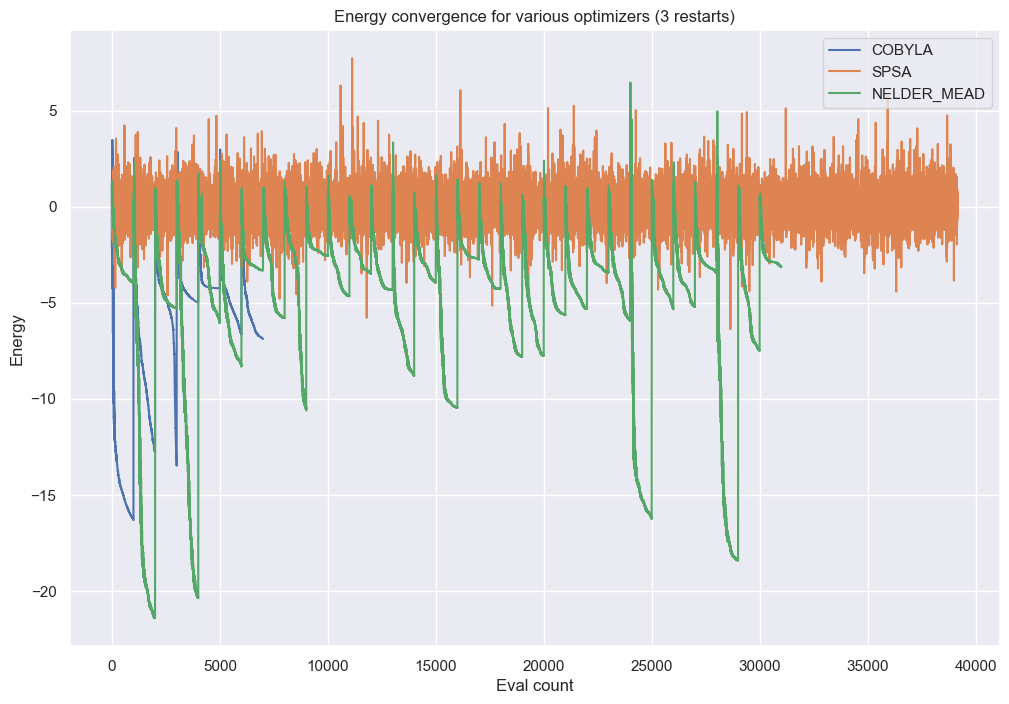

In [70]:
pylab.rcParams['figure.figsize'] = (12, 8)
for i in range(len(optimizers)):
    pylab.plot(converge_cnts_qaoa[i], converge_vals_qaoa[i], label=type(optimizers[i]).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Energy convergence for various optimizers (3 restarts)')
pylab.legend(loc='upper right')

In [71]:
row_dict = {
    "algorithm" : None,
    "iter": None,
    "energy": None   
}

raw_results_qaoa = []

In [72]:
# Loop through and create a dataframe for good clean results
for algo in range(len(converge_cnts_qaoa)):
    for i in zip(converge_cnts_qaoa[algo], converge_vals_qaoa[algo]):
        row_copy = copy.deepcopy(row_dict)
        row_copy["algorithm"] = type(optimizers[algo]).__name__ 
        row_copy["iter"] = i[0]
        row_copy["energy"] = i[1]
        raw_results_qaoa.append(row_copy)
        del row_copy
        
d_results_qaoa = pd.DataFrame(raw_results_qaoa)
d_results_qaoa.to_csv("../data/results-large-maxcut-qaoa.csv")

In [73]:
d_results_qaoa.head()

,algorithm,iter,energy
0,COBYLA,0,-0.697902
1,COBYLA,1,-0.559021
2,COBYLA,2,-2.160636
3,COBYLA,3,1.164425
4,COBYLA,4,0.531147


# Plotting Results

In [74]:
d_results_qaoa.shape

(77156, 3)

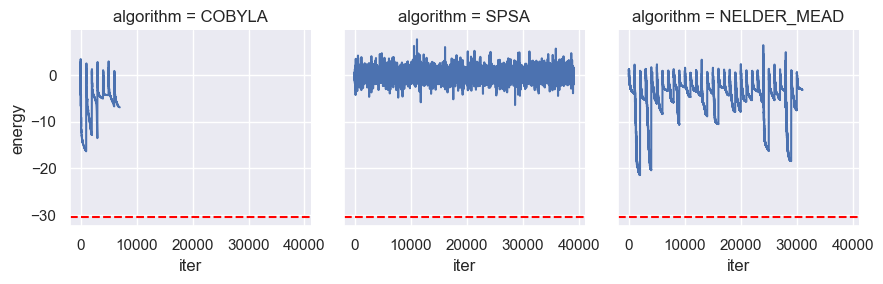

In [75]:
g = sns.FacetGrid(d_results_qaoa, col='algorithm')
g.map(sns.lineplot, 'iter', 'energy')
g.map(plt.axhline, y=actual_result.eigenvalue.real, ls='--', c='red')
plt.show()